In [1]:
from fastai.data.all import *
from fastai.vision.all import *
from fastai.data.transforms import get_image_files
import PIL
import torch
import numpy as np
import os 

In [2]:
DATA_PATH = 'clean'
DATA_PATH_X = 'clean/x-data'
DATA_PATH_Y = 'clean/y-data'
CODES_PATH = "clean/codes.txt"
BATCH_SIZE = 4
IMG_SIZE = (128)

In [3]:
x_files = get_image_files(DATA_PATH_X)
y_files = get_image_files(DATA_PATH_Y)

In [4]:
def open_image(fname, size=IMG_SIZE):
    img = PIL.Image.open(fname).convert('RGB')
    img = img.resize((size, size))
    gray_img = PIL.ImageOps.grayscale(img)
    return torch.Tensor(np.array(gray_img))

In [5]:
def label_func(fname):
    path_y = "clean/y-data/"
    base_name_y = os.path.basename(fname)
    fname_y = os.path.join(path_y, base_name_y)
    return open_image(fname_y, size=(86))

In [6]:
dblock = DataBlock(
    blocks=(ImageBlock, ImageBlock),
    get_items=get_image_files,
    get_x = open_image,
    get_y = label_func,
    )

In [7]:
dls = dblock.dataloaders(
                    DATA_PATH_X, valid_pct=0.2, seed=11, bs=BATCH_SIZE, 
                    batch_tfms=[ 
                    Normalize.from_stats(*imagenet_stats)]
                    )

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


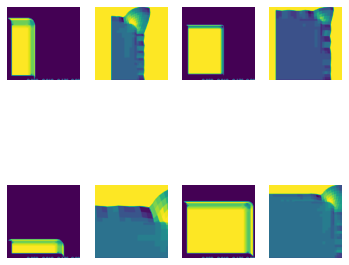

In [8]:
dls.show_batch(figsize=(6,6))

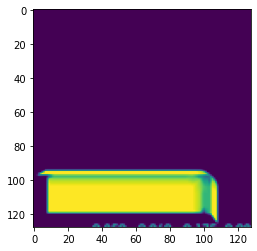

In [9]:
import matplotlib.pyplot as plt

tester = dls[0].one_batch()

plt.imshow(  tester[0][0].permute(1, 2, 0)  )


torch.Size([4, 1, 128, 128])


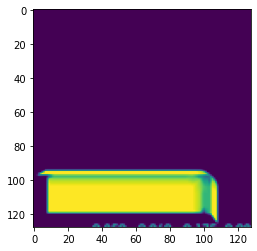

In [10]:
print(tester[0].shape)
plt.imshow(  tester[0][0].permute(1, 2, 0)  )

In [11]:
print(tester.shape)
plt.imshow(  tester[1][0].permute(1, 2, 0)  )

AttributeError: 'tuple' object has no attribute 'shape'

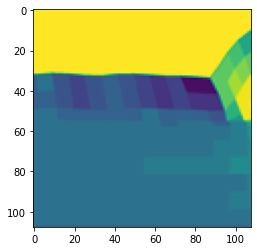

In [12]:
plt.imshow(  tester[1][0].permute(1, 2, 0)  )

## Model

In [13]:
opt = ranger
metric = DiceMulti

In [14]:
def conv(ni, nf, ks=3, act=True):
    res = torch.nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = torch.nn.Sequential(
        res, 
        torch.nn.ReLU(), 
        torch.nn.MaxPool2d(kernel_size=2, stride=2))
    return res

In [15]:
def deconv(ni, nf, ks=3, act=True):
    res = torch.nn.ConvTranspose2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = torch.nn.Sequential(
        res, 
        torch.nn.ReLU(), 
        torch.nn.Upsample(scale_factor=2, mode='bilinear'))
    return res

In [19]:
cnn = torch.nn.Sequential(
    conv(1 ,8, ks=5),        #14x14
    conv(8 ,16),             #7x7
    conv(16,32),             #4x4        
    torch.nn.Flatten(),
    deconv(32,16),
    deconv(16,8),
    deconv(8,1)
)

In [17]:
cnn = torch.nn.Sequential(
    conv(1 ,8),        #14x14
    conv(8 ,16),             #7x7
    deconv(16,8),
    deconv(8,1)
)

In [21]:
cnn = torch.nn.Sequential(
    conv(1 ,8, ks=5),        #14x14
    conv(8 ,16),             #7x7
    conv(16,32),             #4x4        
    deconv(32,16),
    deconv(16,8),
    deconv(8,1)
)

In [22]:
input_test = torch.rand(20, 1, 128, 128)
print(input_test.shape)
cnn(input_test).shape

torch.Size([20, 1, 128, 128])


torch.Size([20, 1, 86, 86])

In [135]:
input = torch.randn(1, 16, 12, 12)
downsample = nn.Conv2d(16, 16, 3, stride=2, padding=1)
upsample = nn.ConvTranspose2d(16, 16, 3, stride=2, padding=1)

In [136]:
h = downsample(input)
h.size()

torch.Size([1, 16, 6, 6])

In [141]:
output = upsample(h, output_size=input.size())
output.size()

torch.Size([1, 16, 12, 12])

In [149]:
sizer = (output.size()[0], output.size()[1], output.size()[2]*2, output.size()[3]*2)
sizer

(1, 16, 48, 48)

In [150]:
output = upsample(output, output_size=sizer)
output.size()

torch.Size([1, 16, 48, 48])

In [81]:
learn = Learner(dls, cnn, loss_func=F.cross_entropy, metrics=metric)

In [82]:
learn.summary()

Sequential (Input shape: 4 x 1 x 128 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 8 x 65 x 65     
Conv2d                                    136        True      
ReLU                                                           
____________________________________________________________________________
                     4 x 8 x 32 x 32     
MaxPool2d                                                      
____________________________________________________________________________
                     4 x 16 x 17 x 17    
Conv2d                                    2064       True      
ReLU                                                           
____________________________________________________________________________
                     4 x 16 x 8 x 8      
MaxPool2d                                                      
____________________________________________________________________________
                     4 x 8 x 14 

In [57]:
learn.lr_find()

RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of dimension: 4

In [19]:
learn.fit(2, 0.06)

epoch,train_loss,valid_loss,dice_multi,time


RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of dimension: 4

In [ ]:
# def fit(epochs=1):
#     learn = Learner(dls, cnn(), loss_func=F.cross_entropy,
#                     metrics=metric)
#     learn.fit(epochs, 0.06)
#     return learn